<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [35]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.preprocessing import PolynomialFeatures

In [7]:
data = pd.read_csv('data_clean_v1.csv')

In [8]:
data = data.drop(['Unnamed: 0'], axis=1)

In [9]:
data.dtypes

age                    object
gender                 object
country                object
education              object
role                   object
experience_prog        object
programming_lang_c      int64
experience_ml          object
industry               object
company_size           object
team_size              object
salary                 object
country_group          object
company_size_g         object
team_size_g            object
salary_avg            float64
salary_group           object
role_group             object
dtype: object

In [10]:
data = data[data['country_group'] != 'Other']

In [11]:
data = data.drop(['country_group','company_size', 'salary', 'team_size', 'salary_group','role'], axis=1)

In [12]:
def dist_boxplot_num(data, skip_columns=[]):
    for col in data.select_dtypes(np.number):
        if col not in skip_columns:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            sns.distplot(data[col], ax=axes[0])
            sns.boxplot(data[col], ax=axes[1])
            plt.show()

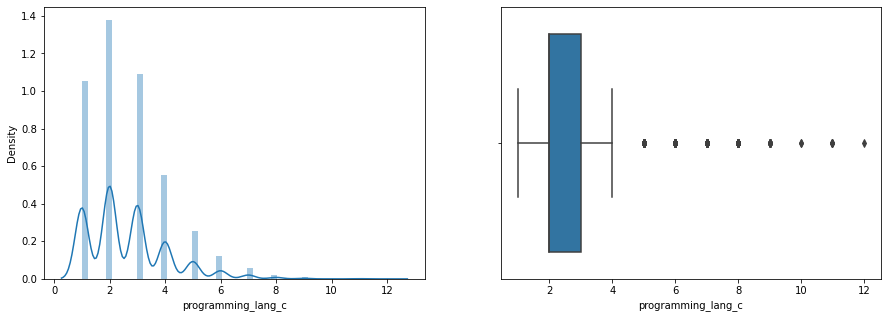

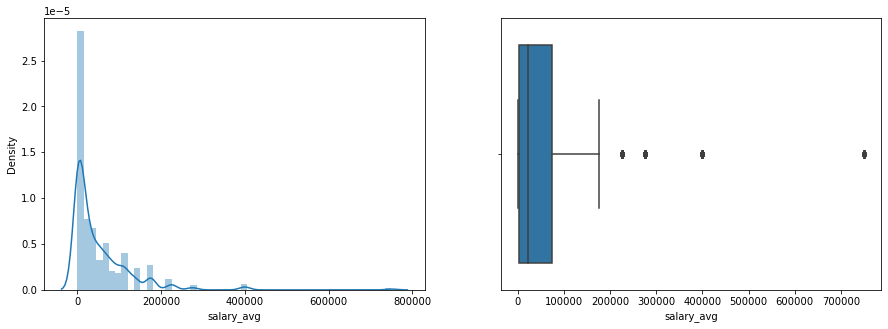

In [13]:
dist_boxplot_num(data)

In [14]:
def boxcox_transform(data, skip_columns=[]):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        if column not in skip_columns:
# since i know any columns should take negative numbers, to avoid -inf in df
            data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
            data[column] = data[column].fillna(data[column].mean())
            transformed_data, ci = stats.boxcox(data[column])
            data[column] = transformed_data
            _ci[column] = [ci] 
    return data, _ci

In [15]:
data, _ci = boxcox_transform(data, skip_columns = ['programming_lang_c'])
data

,age,gender,country,education,experience_prog,programming_lang_c,experience_ml,industry,company_size_g,team_size_g,salary_avg,role_group
0,50-54,Man,India,Bachelor’s degree,5-10 years,2,5-10 years,Manufacturing/Fabrication,Medium,Small,24.915032,Other
4,45-49,Man,India,Doctoral degree,< 1 years,3,10-20 years,Academics/Education,Medium,Small,26.106034,Other
5,30-34,Man,India,Bachelor’s degree,5-10 years,1,2-3 years,Computers/Technology,Large,Small,22.798869,Data Scientist
10,35-39,Man,Greece,Doctoral degree,10-20 years,4,4-5 years,Academics/Education,Medium,Small,21.316701,Data Scientist
11,50-54,Man,Belgium,Bachelor’s degree,20+ years,2,1-2 years,Energy/Mining,Large,Small,15.201037,Data Analyst
...,...,...,...,...,...,...,...,...,...,...,...,...
14367,18-21,Man,India,Bachelor’s degree,1-3 years,2,Under 1 year,Academics/Education,Small,No team,10.431093,Data Analyst
14369,35-39,Man,Italy,Bachelor’s degree,3-5 years,2,1-2 years,Computers/Technology,Large,Small,29.374205,Data Analyst
14370,18-21,Man,India,Bachelor’s degree,1-3 years,4,Under 1 year,Academics/Education,Small,Small,10.431093,Data Engineer
14371,60-69,Man,USA,Bachelor’s degree,20+ years,2,Under 1 year,Academics/Education,Large,Small,40.986080,Data Analyst


In [16]:
def remove_outliers(data, threshold=1.5, in_columns=data.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(data[column],75)
            lower = np.percentile(data[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            data = data[(data[column]>lower_limit) & (data[column]<upper_limit)]
    return data

In [18]:
data = remove_outliers(data, threshold=1.5)

In [19]:
data.shape

(6927, 12)

In [21]:
corr_df_model = data.select_dtypes([np.number])
correlations_matrix = corr_df_model.corr()  # method='spearman'
correlations_matrix

,programming_lang_c,salary_avg
programming_lang_c,1.000000,0.067854
salary_avg,0.067854,1.000000


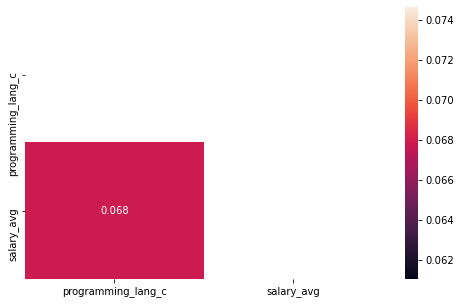

In [22]:
mask = np.zeros_like(correlations_matrix)

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [24]:
data_cat = data.select_dtypes(np.object)
data_num = data.select_dtypes(np.number)

In [26]:
corr_mat = data_cat.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')

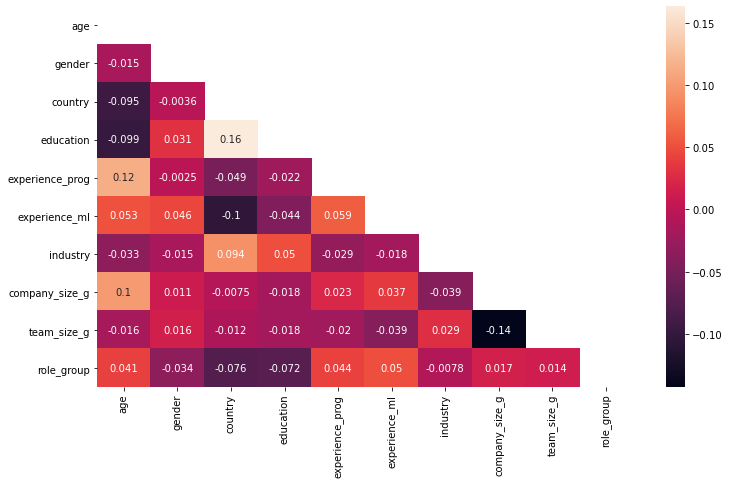

In [27]:
mask = np.zeros_like(corr_mat)

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(12, 7))
ax = sns.heatmap((corr_mat), mask=mask, annot=True)
plt.show()

In [29]:
def col_cat_val(data, columns=[]):
    for i in columns:
        for j in columns:
            if i != j:
                data_crosstab = pd.crosstab(data[i], data[j], margins = False)
                print (i,"vs", j)
                print (chi2_contingency(data_crosstab, correction=False), '\n')

In [30]:
col_cat_val(data_cat, columns= data.select_dtypes(np.object))

age vs gender
(57.35870398872379, 1.8106382196124923e-05, 20, array([[3.22962033e+02, 6.66493431e+00, 6.83730331e+01],
       [8.11462394e+02, 1.67460661e+01, 1.71791540e+02],
       [1.14172759e+03, 2.35617150e+01, 2.41710697e+02],
       [9.71320485e+02, 2.00450411e+01, 2.05634474e+02],
       [7.35184929e+02, 1.51719359e+01, 1.55643136e+02],
       [5.33130793e+02, 1.10021654e+01, 1.12867042e+02],
       [4.00862422e+02, 8.27255666e+00, 8.48650209e+01],
       [2.86446225e+02, 5.91136134e+00, 6.06424137e+01],
       [2.02054136e+02, 4.16977046e+00, 4.27760935e+01],
       [1.78521727e+02, 3.68413455e+00, 3.77941389e+01],
       [3.73272701e+01, 7.70319041e-01, 7.90241086e+00]])) 

age vs country
(1746.876670533696, 3.9892498242954494e-240, 210, array([[1.66623358e+00, 1.72368991e+00, 2.47062220e+00, 2.29825321e+00,
        2.01097156e+00, 1.39618883e+01, 1.59154035e+01, 3.79211780e+00,
        1.59268948e+02, 3.21755450e+00, 1.10316154e+01, 5.80308936e+00,
        7.81406092e+00, 4.

age vs role_group
(352.56600378983643, 9.627475410420156e-57, 30, array([[ 99.28453876, 108.93720225, 134.79255089,  54.9857081 ],
       [249.4586401 , 273.71156345, 338.67475097, 138.15504547],
       [350.98830663, 385.11216977, 476.51537462, 194.38414898],
       [298.6019922 , 327.63274145, 405.39367692, 165.37158943],
       [226.00952793, 247.98267648, 306.83932438, 125.1684712 ],
       [163.89432655, 179.82849718, 222.50931139,  90.76786488],
       [123.23256821, 135.21351234, 167.30532698,  68.24859246],
       [ 88.05889996,  96.6201819 , 119.55218709,  48.76873105],
       [ 62.11520139,  68.1541793 ,  84.33001299,  34.40060632],
       [ 54.88090082,  60.21654396,  74.50844521,  30.39411   ],
       [ 11.47509744,  12.59073192,  15.57903854,   6.35513209]])) 

gender vs age
(57.35870398872379, 1.8106382196124923e-05, 20, array([[3.22962033e+02, 8.11462394e+02, 1.14172759e+03, 9.71320485e+02,
        7.35184929e+02, 5.33130793e+02, 4.00862422e+02, 2.86446225e+02,
        2

country vs role_group
(248.3907807315674, 7.694423971180323e-24, 63, array([[  7.23430056,   7.93763534,   9.82156778,   4.00649632],
       [  7.4837592 ,   8.2113469 ,  10.16024253,   4.14465136],
       [ 10.72672152,  11.76959723,  14.56301429,   5.94066696],
       [  9.9783456 ,  10.94846254,  13.54699004,   5.52620182],
       [  8.7310524 ,   9.57990472,  11.85361628,   4.83542659],
       [ 60.61844955,  66.51190992,  82.29796449,  33.57167605],
       [ 69.10004331,  75.81810307,  93.81290602,  38.2689476 ],
       [ 16.46427025,  18.06496319,  22.35253356,   9.118233  ],
       [691.49935037, 758.72845388, 938.8064097 , 382.96578605],
       [ 13.96968385,  15.32784755,  18.96578605,   7.73668255],
       [ 47.8960589 ,  52.55262018,  65.02555219,  26.52576873],
       [ 25.19532265,  27.64486791,  34.20614985,  13.95365959],
       [ 33.92637505,  37.22477263,  46.05976613,  18.78908618],
       [ 18.70939801,  20.52836726,  25.40060632,  10.36162841],
       [  9.72888696,

education vs team_size_g
(117.09801889745194, 1.4778534480257428e-16, 18, array([[ 561.05557962,  195.73711563,  311.56979934,  922.63750541],
       [ 292.78591021,  102.14508445,  162.59217554,  481.4768298 ],
       [  19.72571099,    6.881767  ,   10.95423704,   32.43828497],
       [  35.78807565,   12.48549155,   19.87411578,   58.85231702],
       [ 943.45257687,  329.14508445,  523.92550888, 1551.4768298 ],
       [  38.60603436,   13.46860113,   21.43900679,   63.48635773],
       [  60.58611231,   21.13685578,   33.64515663,   99.63187527]])) 

education vs role_group
(705.7313492342331, 3.44881463475316e-138, 18, array([[ 496.67215245,  544.95972282,  674.30142919,  275.06669554],
       [ 259.18752707,  284.38631442,  351.88306626,  143.54309225],
       [  17.46210481,   19.15980944,   23.70723257,    9.67085318],
       [  31.68124729,   34.76136856,   43.01169337,   17.54569078],
       [ 835.18752707,  916.38631442, 1133.88306626,  462.54309225],
       [  34.17583369, 

experience_prog vs team_size_g
(265.4551473523676, 8.051828528574641e-48, 15, array([[474.82604302, 165.65396275, 263.68413455, 780.83585968],
       [259.5339974 ,  90.54439151, 144.12646167, 426.79514942],
       [213.60127039,  74.5197055 , 118.61873827, 351.26028584],
       [330.26476108, 115.22044175, 183.40522593, 543.10957124],
       [342.66377941, 119.54612386, 190.29074635, 563.49935037],
       [331.11014869, 115.51537462, 183.87469323, 544.49978346]])) 

experience_prog vs role_group
(349.285455642133, 2.963782102831931e-65, 15, array([[420.33780858, 461.20398441, 570.66695539, 232.79125162],
       [229.75140754, 252.08834994, 311.91944565, 127.24079688],
       [189.0896492 , 207.47336509, 256.71546124, 104.72152447],
       [292.3655262 , 320.78995236, 396.92680814, 161.9177133 ],
       [303.34170637, 332.83326115, 411.82849718, 167.9965353 ],
       [293.11390212, 321.61108705, 397.94283239, 162.33217843]])) 

experience_ml vs age
(1197.2429716666165, 1.12344197217803

experience_ml vs company_size_g
(83.25948583845394, 4.279689097058333e-11, 16, array([[ 810.8469756 ,  201.1193879 ,  325.03363649],
       [ 117.04821712,   29.03219287,   46.91959001],
       [ 481.5351523 ,  119.43814061,  193.02670709],
       [  55.79500505,   13.83918002,   22.36581493],
       [ 294.13671142,   72.95654685,  117.90674174],
       [ 271.09094846,   67.24036379,  108.66868774],
       [ 323.85361628,   80.32741447,  129.81896925],
       [ 559.76945287,  138.84307781,  224.38746932],
       [1286.92392089,  319.20369568,  515.87238343]])) 

experience_ml vs team_size_g
(616.9577820414665, 6.6889781492510245e-115, 24, array([[376.76107983, 131.44174968, 209.22592753, 619.57124296],
       [ 54.38660315,  18.97401472,  30.20239642,  89.43698571],
       [223.74592176,  78.05889996, 124.25234589, 367.94283239],
       [ 25.92522015,   9.04460806,  14.39699726,  42.63317453],
       [136.67099755,  47.68081421,  75.8972138 , 224.75097445],
       [125.96275444,  43.94

industry vs company_size_g
(318.52632556690116, 6.190995859916492e-48, 34, array([[ 684.70174679,  169.83080699,  274.46744622],
       [ 391.77797026,   97.17511188,  157.04691786],
       [  91.57658438,   22.71430634,   36.70910928],
       [1111.04836148,  275.58019345,  445.37144507],
       [ 129.78403349,   32.19113613,   52.02483037],
       [ 158.28800346,   39.26115201,   63.45084452],
       [  51.54973293,   12.78619893,   20.66406814],
       [ 141.91338242,   35.19965353,   56.88696405],
       [ 197.10192002,   48.88840768,   79.0096723 ],
       [ 101.28006352,   25.12112025,   40.59881623],
       [ 226.81882489,   56.2592753 ,   90.92189981],
       [  69.13728887,   17.14854916,   27.71416197],
       [  49.73033059,   12.33492132,   19.93474809],
       [  74.59549589,   18.50238198,   29.90212213],
       [ 181.33376642,   44.97733507,   72.68889851],
       [ 300.80785333,   74.61123141,  120.58091526],
       [ 149.19099177,   37.00476397,   59.80424426],
       

team_size_g vs role_group
(244.7275670339058, 1.2933691891324353e-47, 9, array([[ 486.94326548,  534.28497185,  661.0931139 ,  269.67864877],
       [ 169.88133391,  186.39757471,  230.63750541,   94.08358597],
       [ 270.41316587,  296.70333478,  367.12343006,  149.76006929],
       [ 800.76223473,  878.61411867, 1087.14595063,  443.47769597]])) 

role_group vs age
(352.5660037898364, 9.627475410420432e-57, 30, array([[ 99.28453876, 249.4586401 , 350.98830663, 298.6019922 ,
        226.00952793, 163.89432655, 123.23256821,  88.05889996,
         62.11520139,  54.88090082,  11.47509744],
       [108.93720225, 273.71156345, 385.11216977, 327.63274145,
        247.98267648, 179.82849718, 135.21351234,  96.6201819 ,
         68.1541793 ,  60.21654396,  12.59073192],
       [134.79255089, 338.67475097, 476.51537462, 405.39367692,
        306.83932438, 222.50931139, 167.30532698, 119.55218709,
         84.33001299,  74.50844521,  15.57903854],
       [ 54.9857081 , 138.15504547, 194.38414

In [31]:
X = data.drop('salary_avg', axis=1)
y = data['salary_avg']

In [32]:
from sklearn.preprocessing import OrdinalEncoder

In [33]:
encoder = OrdinalEncoder()
X = encoder.fit_transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.33133801832449594


In [38]:
clf = RandomForestRegressor(random_state=0, max_features='auto', min_samples_leaf=1,min_samples_split=2, max_depth=12, n_estimators=500)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.5554667969885456


In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 80, 100, 200, 400, 500],
    'min_samples_split': [1,2,4, 5, 10, 15],
    #'min_leaf_size': [50, 60, 70],
    'min_samples_leaf' : [1, 2, 3, 4, 5],
    'max_depth': [8, 12, 14, 16, 18, 20],
    'max_features': ['sqrt', 'auto', 'log2']
#    'max_samples' : ['None', 0.5]
    }
clf = RandomForestRegressor(random_state=100)

grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X_train,y_train)
grid_search.best_params_ #To check the best set of parameters returned

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [41]:
clf = RandomForestRegressor(random_state=0, max_features='sqrt', min_samples_leaf=1,min_samples_split=10, max_depth=20, n_estimators=200)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.5569458173566357


In [42]:
# Use the forest's predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 4.17 degrees.


In [43]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.54 %.


In [44]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
from sklearn.metrics import mean_squared_error
MSE= mean_squared_error(y_test, y_pred, squared=False)
#MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 
import math
RMSE = math.sqrt(MSE)
print(RMSE)

2.3575671853377207


In [47]:
clf.fit(X_train, y_train)
#X_train.head()
feature_names = X_train.columns
feature_names = list(feature_names)

df_fs = pd.DataFrame(list(zip(feature_names, clf.feature_importances_)))
df_fs.columns = ['columns_name', 'score_feature_importance']
df_fs.sort_values(by=['score_feature_importance'], ascending = False)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'